## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Read & Normalize Dataset

In [2]:
df = pd.read_excel("Stock.xlsx")
df.columns = ['Price']

In [3]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df[['Price']].values)

## Dataset Visualization 

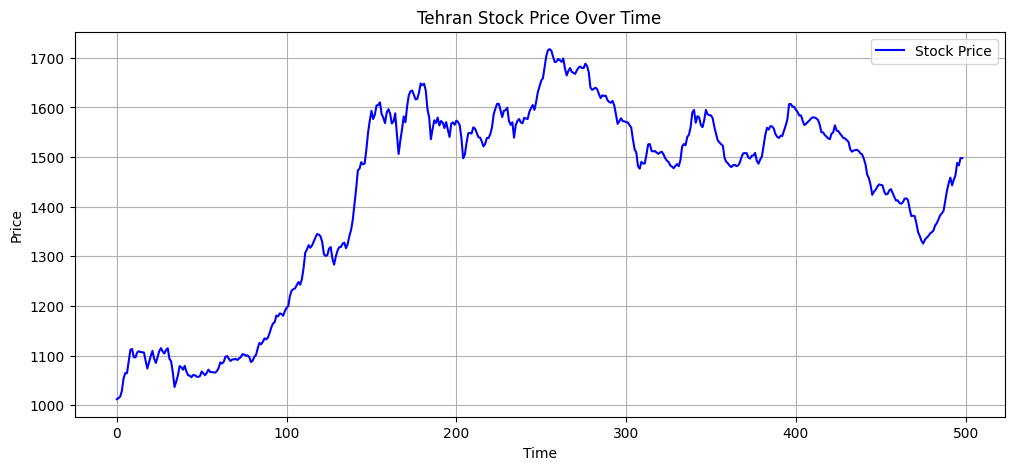

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], label='Stock Price', color='blue')
plt.title("Tehran Stock Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

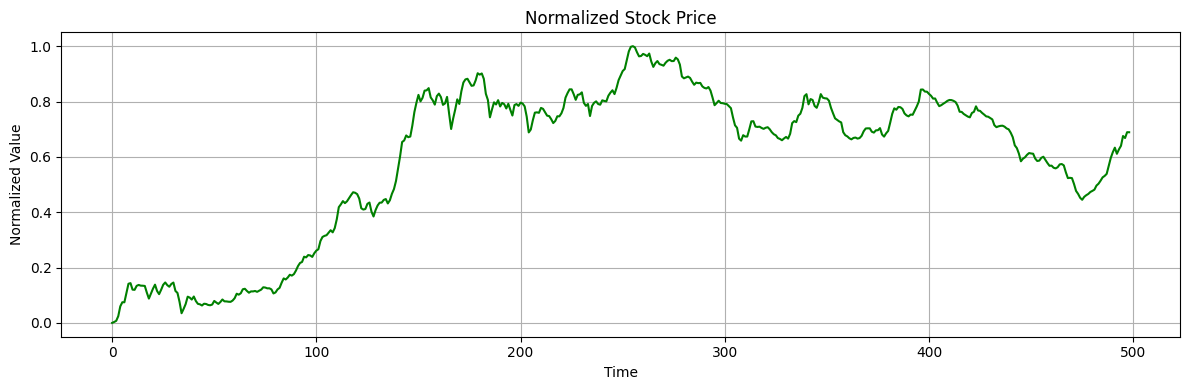

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(normalized_data, color='green')
plt.title("Normalized Stock Price")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.grid(True)
plt.tight_layout()
plt.show()

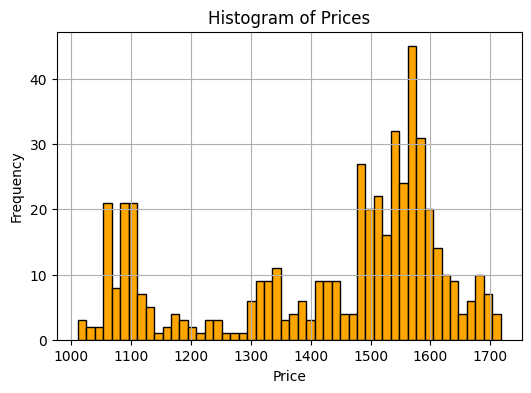

In [19]:
plt.figure(figsize=(6, 4))
plt.hist(df['Price'], bins=50, color='orange', edgecolor='black')
plt.title("Histogram of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Hyperparameters

In [21]:
INPUT_DIM = 1
HIDDEN_DIM = 64
OUTPUT_DIM = 1
TIMESTEPS = 10
PREDICT_AHEAD = 2
TRAIN_RATIO = 0.8
EPOCHS = 100
LEARNING_RATE = 0.01
SEED = 13

In [17]:
np.random.seed(SEED)

## Sequence generation

In [5]:
def create_sequences(data, timesteps=10, predict_ahead=2):
    X, y = [], []
    for i in range(len(data) - timesteps - predict_ahead + 1):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps + predict_ahead - 1])
    return np.array(X), np.array(y)

## Base LSTM Cell with BPTT

In [25]:
class LSTMCellTrainable:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        def init_weight():
            return np.random.randn(hidden_dim, input_dim + hidden_dim) / np.sqrt(input_dim + hidden_dim)

        self.Wf, self.bf = init_weight(), np.zeros((hidden_dim, 1))
        self.Wi, self.bi = init_weight(), np.zeros((hidden_dim, 1))
        self.Wc, self.bc = init_weight(), np.zeros((hidden_dim, 1))
        self.Wo, self.bo = init_weight(), np.zeros((hidden_dim, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x_seq):
        h = np.zeros((self.hidden_dim, 1))
        c = np.zeros((self.hidden_dim, 1))
        self.cache = []

        for xt in x_seq:
            xt = xt.reshape(-1, 1)
            concat = np.vstack((h, xt))
            ft = self.sigmoid(self.Wf @ concat + self.bf)
            it = self.sigmoid(self.Wi @ concat + self.bi)
            ct_tilde = np.tanh(self.Wc @ concat + self.bc)
            c = ft * c + it * ct_tilde
            ot = self.sigmoid(self.Wo @ concat + self.bo)
            h = ot * np.tanh(c)

            self.cache.append({
                'xt': xt, 'concat': concat,
                'ft': ft, 'it': it, 'ct_tilde': ct_tilde, 'ot': ot,
                'c': c.copy(), 'h': h.copy()
            })

        return h

    def zero_grads(self):
        self.dWf = np.zeros_like(self.Wf)
        self.dbf = np.zeros_like(self.bf)
        self.dWi = np.zeros_like(self.Wi)
        self.dbi = np.zeros_like(self.bi)
        self.dWc = np.zeros_like(self.Wc)
        self.dbc = np.zeros_like(self.bc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbo = np.zeros_like(self.bo)

    def backward(self, dh_next, dc_next):
        self.zero_grads()
        for t in reversed(range(len(self.cache))):
            cache = self.cache[t]
            xt, concat = cache['xt'], cache['concat']
            ft, it, ct_tilde, ot, c, h = cache['ft'], cache['it'], cache['ct_tilde'], cache['ot'], cache['c'], cache['h']
            c_prev = self.cache[t - 1]['c'] if t > 0 else np.zeros_like(c)

            tanh_c = np.tanh(c)
            d_o = dh_next * tanh_c * ot * (1 - ot)
            d_c = dh_next * ot * (1 - tanh_c ** 2) + dc_next
            d_f = d_c * c_prev * ft * (1 - ft)
            d_i = d_c * ct_tilde * it * (1 - it)
            d_cct = d_c * it * (1 - ct_tilde ** 2)

            self.dWf += d_f @ concat.T
            self.dbf += d_f
            self.dWi += d_i @ concat.T
            self.dbi += d_i
            self.dWc += d_cct @ concat.T
            self.dbc += d_cct
            self.dWo += d_o @ concat.T
            self.dbo += d_o

            d_concat = (
                self.Wf.T @ d_f +
                self.Wi.T @ d_i +
                self.Wc.T @ d_cct +
                self.Wo.T @ d_o
            )
            dh_next = d_concat[:self.hidden_dim, :]
            dc_next = d_c * ft

    def apply_grads(self, lr=0.01):
        for param, grad in zip(
            [self.Wf, self.bf, self.Wi, self.bi, self.Wc, self.bc, self.Wo, self.bo],
            [self.dWf, self.dbf, self.dWi, self.dbi, self.dWc, self.dbc, self.dWo, self.dbo]
        ):
            param -= lr * grad

## Bidirectional LSTM with BPTT

In [26]:
class BidirectionalLSTMTrainable:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.fw_lstm = LSTMCellTrainable(input_dim, hidden_dim)
        self.bw_lstm = LSTMCellTrainable(input_dim, hidden_dim)
        self.W_fc = np.random.randn(output_dim, 2 * hidden_dim) / np.sqrt(2 * hidden_dim)
        self.b_fc = np.zeros((output_dim, 1))

        self.dW_fc = np.zeros_like(self.W_fc)
        self.db_fc = np.zeros_like(self.b_fc)

    def forward(self, x_seq):
        fw_h = self.fw_lstm.forward(x_seq)
        bw_h = self.bw_lstm.forward(x_seq[::-1])
        self.concat = np.vstack((fw_h, bw_h))  # (2 * hidden_dim, 1)
        output = self.W_fc @ self.concat + self.b_fc
        return output.flatten()

    def backward(self, d_output):
        d_output = d_output.reshape(-1, 1)
        self.dW_fc = d_output @ self.concat.T
        self.db_fc = d_output

        d_concat = self.W_fc.T @ d_output
        d_fw = d_concat[:self.fw_lstm.hidden_dim, :]
        d_bw = d_concat[self.fw_lstm.hidden_dim:, :]

        self.fw_lstm.backward(d_fw, np.zeros_like(d_fw))
        self.bw_lstm.backward(d_bw, np.zeros_like(d_bw))

    def apply_grads(self, lr=0.01):
        self.W_fc -= lr * self.dW_fc
        self.b_fc -= lr * self.db_fc
        self.fw_lstm.apply_grads(lr)
        self.bw_lstm.apply_grads(lr)

## Train

In [27]:
def train_bptt(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.01):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        train_loss = 0
        for i in range(len(X_train)):
            y_pred = model.forward(X_train[i])
            loss = np.mean((y_pred - y_train[i]) ** 2)
            train_loss += loss

            d_loss = 2 * (y_pred - y_train[i])
            model.backward(d_loss)
            model.apply_grads(lr)

        train_losses.append(train_loss / len(X_train))

        # Eval
        test_loss = 0
        for i in range(len(X_test)):
            y_pred = model.forward(X_test[i])
            test_loss += np.mean((y_pred - y_test[i]) ** 2)

        test_losses.append(test_loss / len(X_test))
        print(f"Epoch {epoch+1}: Train MSE = {train_losses[-1]:.6f}, Test MSE = {test_losses[-1]:.6f}")

    return train_losses, test_losses

## Main

### Create sequence

In [28]:
X, y = create_sequences(normalized_data, TIMESTEPS, PREDICT_AHEAD)

## Split data

In [29]:
split_index = int(TRAIN_RATIO * len(X))
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

In [30]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (390, 10, 1) (390, 1)
Test shape: (98, 10, 1) (98, 1)


In [31]:
model = BidirectionalLSTMTrainable(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
train_loss, test_loss = train_bptt(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, lr=LEARNING_RATE)

Epoch 1: Train MSE = 0.013172, Test MSE = 0.016783
Epoch 2: Train MSE = 0.019922, Test MSE = 0.012978
Epoch 3: Train MSE = 0.014249, Test MSE = 0.010193
Epoch 4: Train MSE = 0.010209, Test MSE = 0.008169
Epoch 5: Train MSE = 0.007425, Test MSE = 0.006717
Epoch 6: Train MSE = 0.005558, Test MSE = 0.005690
Epoch 7: Train MSE = 0.004331, Test MSE = 0.004970
Epoch 8: Train MSE = 0.003531, Test MSE = 0.004468
Epoch 9: Train MSE = 0.003012, Test MSE = 0.004117
Epoch 10: Train MSE = 0.002672, Test MSE = 0.003868
Epoch 11: Train MSE = 0.002446, Test MSE = 0.003690
Epoch 12: Train MSE = 0.002294, Test MSE = 0.003561
Epoch 13: Train MSE = 0.002189, Test MSE = 0.003464
Epoch 14: Train MSE = 0.002114, Test MSE = 0.003391
Epoch 15: Train MSE = 0.002059, Test MSE = 0.003334
Epoch 16: Train MSE = 0.002018, Test MSE = 0.003288
Epoch 17: Train MSE = 0.001987, Test MSE = 0.003251
Epoch 18: Train MSE = 0.001961, Test MSE = 0.003220
Epoch 19: Train MSE = 0.001940, Test MSE = 0.003194
Epoch 20: Train MSE =

## Result

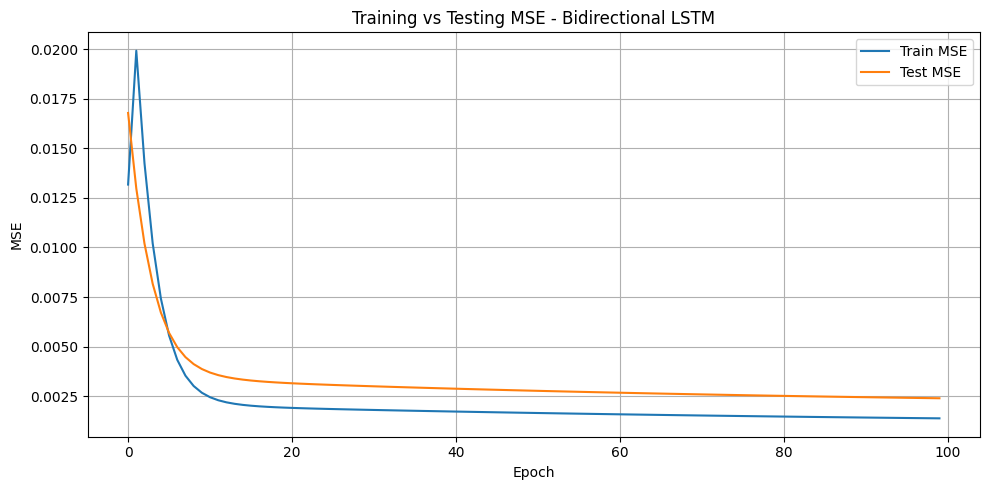

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train MSE")
plt.plot(test_loss, label="Test MSE")
plt.title("Training vs Testing MSE - Bidirectional LSTM")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()